In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
stk_list = pd.read_csv("data/stock_list.csv")
stk_list = stk_list[~stk_list['industry_category'].isin(['ETF','ETN','上櫃指數股票型基金(ETF)','受益證券','指數投資證券(ETN)','其他','所有證券','創新板股票','存託憑證', 'Index', '大盤'])]
stk_list = stk_list[stk_list['type'].isin(['twse'])]
stk_list = stk_list[stk_list['stock_id'].apply(lambda x: len(x) == 4)]
stk_list

,industry_category,stock_id,stock_name,type,date
355,水泥工業,1101,台泥,twse,2023-12-14
357,水泥工業,1102,亞泥,twse,2023-12-14
358,水泥工業,1103,嘉泥,twse,2023-12-14
359,水泥工業,1104,環泥,twse,2023-12-14
361,水泥工業,1108,幸福,twse,2023-12-14
...,...,...,...,...,...
3165,觀光事業,9943,好樂迪,twse,2023-06-29
3166,觀光餐旅,9943,好樂迪,twse,2023-12-14
3169,建材營造,9946,三發地產,twse,2023-12-14
3174,綠能環保,9955,佳龍,twse,2023-12-14


In [3]:
stock_ids = stk_list['stock_id'].unique()

#load data
df_trading = pd.read_csv('data/all_stock_close_price_from2023-11-15to2023-12-15.csv')
df_broker = pd.read_csv('data/9217_from2023-11-15to2023-12-15_trader_trading.csv')

# 過濾出要分析的股票 而不是ETF等等
df_broker = df_broker[df_broker['stock_id'].isin(stock_ids)]

# 按日期分組，選取每天買進量前二十的股票
top20_buys_daily = df_broker.groupby('date').apply(lambda x: x.sort_values('buy', ascending=False).head(20)).reset_index(drop=True)

# 計算每支股票每天的總買進量
broker_buy_sum = top20_buys_daily.groupby(['stock_id', 'date'])['buy'].sum().reset_index()

# 合併到每日成交資料中
df_combined = pd.merge(df_trading, broker_buy_sum, on=['stock_id', 'date'], how='left')


# 計算買進比例
df_combined['buy_ratio'] = df_combined['buy'] / df_combined['Trading_Volume']

In [4]:
# 對日期進行排序，以便計算隔天價格
df_combined.sort_values(by=['stock_id', 'date'], inplace=True)

# 計算隔天的股價變化
df_combined['next_day_close'] = df_combined.groupby('stock_id')['close'].shift(-1)
df_combined['price_change'] = df_combined['next_day_close'] - df_combined['close']
df_combined['price_change_percentage'] = (df_combined['price_change'] / df_combined['close']) * 100



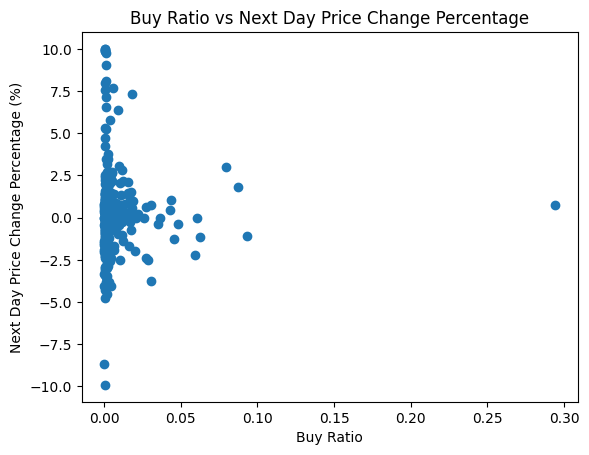

In [5]:
# 繪製散點圖
plt.scatter(df_combined['buy_ratio'], df_combined['price_change_percentage'])

# 隨機選擇部分點進行標注
sampled_points = df_combined.sample(n=20)
for index, row in sampled_points.iterrows():
    plt.annotate(f"{row['stock_id']} ({row['date']}, {row['price_change_percentage']:.2f}%)",
                 (row['buy_ratio'], row['price_change_percentage']))

plt.xlabel('Buy Ratio')
plt.ylabel('Next Day Price Change Percentage (%)')
plt.title('Buy Ratio vs Next Day Price Change Percentage')
plt.show()

True
True


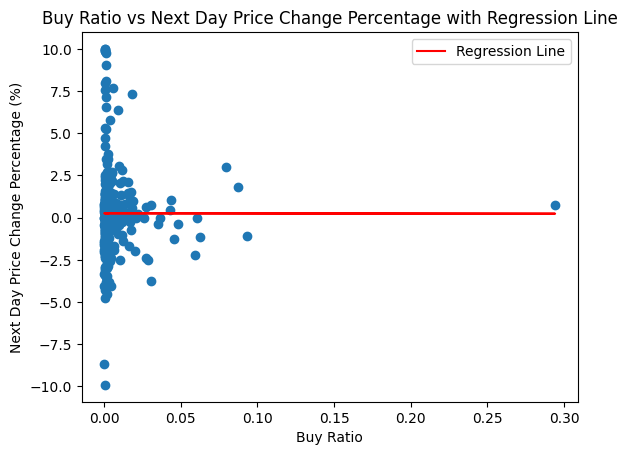

In [6]:

print(df_combined['buy_ratio'].isnull().any())
print(df_combined['price_change_percentage'].isnull().any())

# 移除NaN值
df_combined = df_combined.dropna(subset=['buy_ratio', 'price_change_percentage'])
# 使用numpy計算線性回歸的參數
slope, intercept = np.polyfit(df_combined['buy_ratio'], df_combined['price_change_percentage'], 1)


# 移除NaN值
df_combined = df_combined.dropna(subset=['buy_ratio', 'price_change_percentage'])
# 繪製散點圖
plt.scatter(df_combined['buy_ratio'], df_combined['price_change_percentage'])

# 繪製回歸線
x = np.array(df_combined['buy_ratio'])
plt.plot(x, intercept + slope * x, color='red', label='Regression Line')

# 添加標籤和標題
plt.xlabel('Buy Ratio')
plt.ylabel('Next Day Price Change Percentage (%)')
plt.title('Buy Ratio vs Next Day Price Change Percentage with Regression Line')
plt.legend()

# 顯示圖形
plt.show()


In [7]:
# 改追蹤接下來五天的股價變化
# 對日期進行排序，以便計算隔天價格
df_combined.sort_values(by=['stock_id', 'date'], inplace=True)

# 計算隔天及後續四天的股價變化
df_combined['next_day_close'] = df_combined.groupby('stock_id')['close'].shift(-1)
df_combined['price_change_next_day'] = (df_combined['next_day_close'] - df_combined['close']) / df_combined['close'] * 100

for i in range(2, 6):
    df_combined[f'price_change_day_{i}'] = (df_combined.groupby('stock_id')['close'].shift(-i) - df_combined['close']) / df_combined['close'] * 100




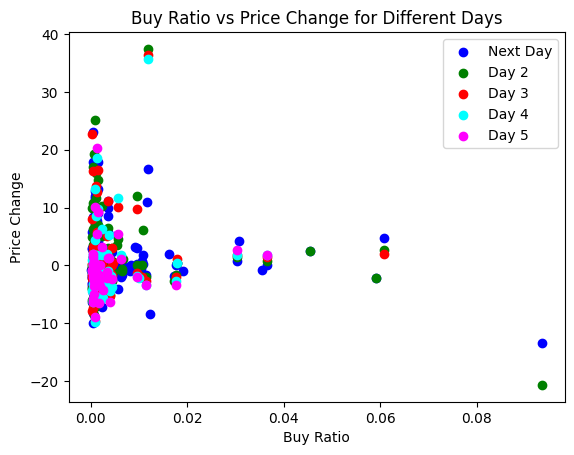

In [8]:
# 繪製散點圖
plt.scatter(df_combined['buy_ratio'], df_combined['price_change_next_day'], color='blue', label='Next Day')
plt.scatter(df_combined['buy_ratio'], df_combined['price_change_day_2'], color='green', label='Day 2')
plt.scatter(df_combined['buy_ratio'], df_combined['price_change_day_3'], color='red', label='Day 3')
plt.scatter(df_combined['buy_ratio'], df_combined['price_change_day_4'], color='cyan', label='Day 4')
plt.scatter(df_combined['buy_ratio'], df_combined['price_change_day_5'], color='magenta', label='Day 5')

# 添加標籤和標題
plt.xlabel('Buy Ratio')
plt.ylabel('Price Change')
plt.title('Buy Ratio vs Price Change for Different Days')
plt.legend()

# 顯示圖形
plt.show()

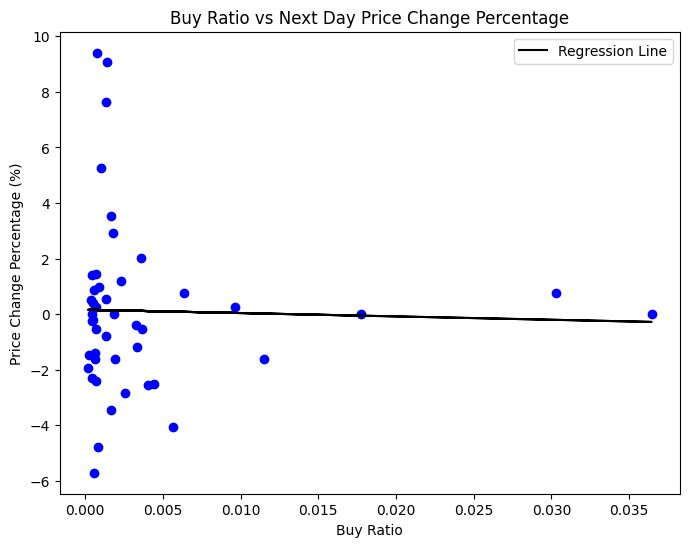

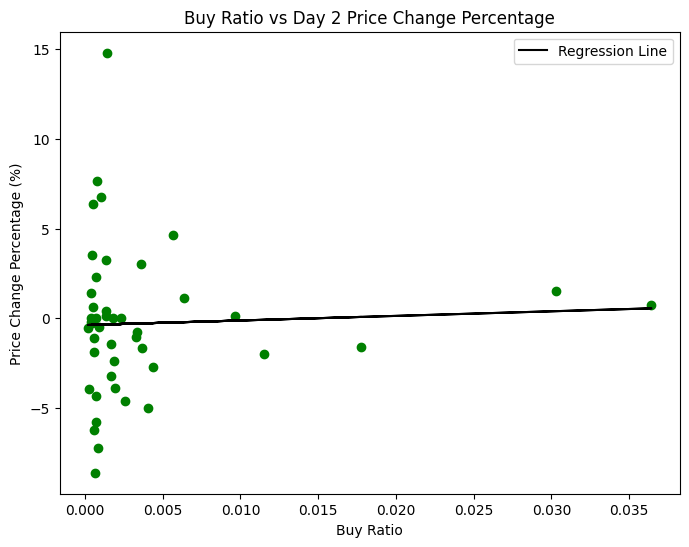

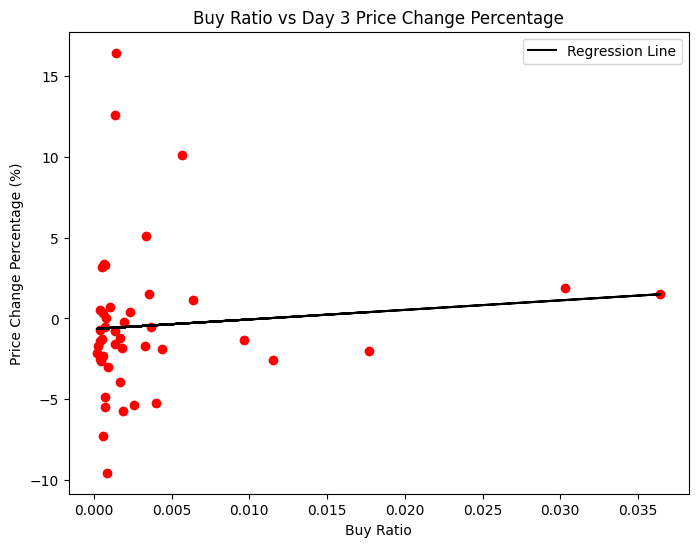

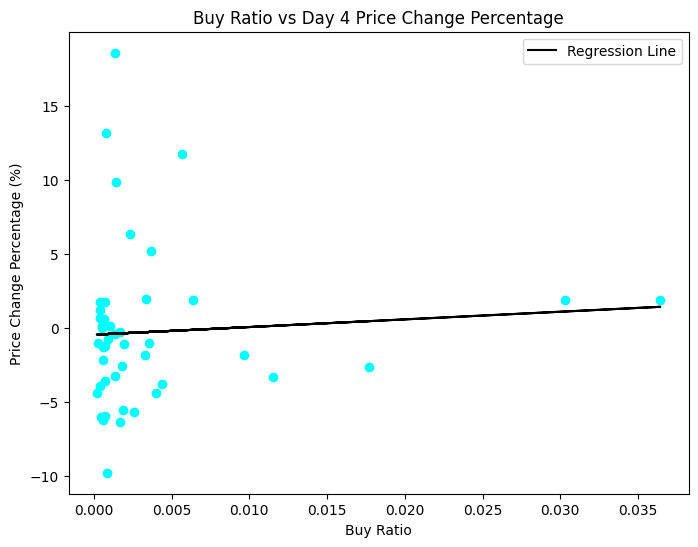

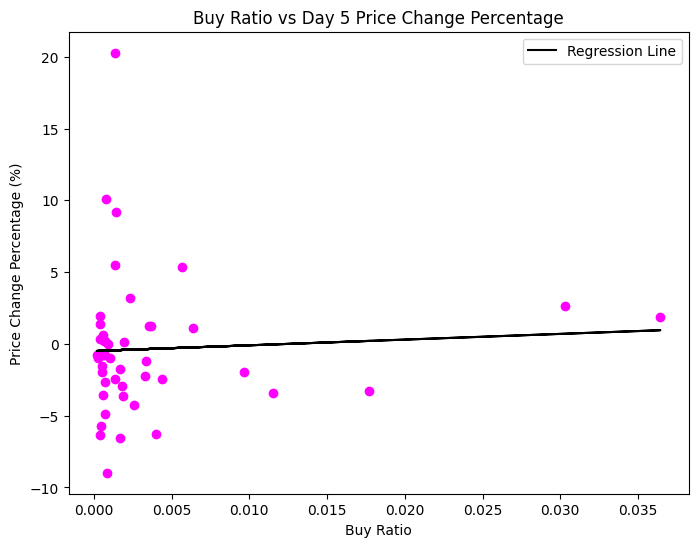

In [9]:
# 計算回歸線參數並繪製散點圖及回歸線的函數
def plot_with_regression(x, y, title, color):
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color=color)

    # 計算回歸線參數
    slope, intercept = np.polyfit(x, y, 1)
    plt.plot(x, slope * x + intercept, color='black', label='Regression Line')

    plt.xlabel('Buy Ratio')
    plt.ylabel('Price Change Percentage (%)')
    plt.title(title)
    plt.legend()
    plt.show()

# 去除含有NaN值的行
df_combined.dropna(subset=['price_change_next_day', 'price_change_day_2', 'price_change_day_3', 'price_change_day_4', 'price_change_day_5'], inplace=True)

# 繪製每一天的散點圖和回歸線
plot_with_regression(df_combined['buy_ratio'], df_combined['price_change_next_day'], 'Buy Ratio vs Next Day Price Change Percentage', 'blue')
plot_with_regression(df_combined['buy_ratio'], df_combined['price_change_day_2'], 'Buy Ratio vs Day 2 Price Change Percentage', 'green')
plot_with_regression(df_combined['buy_ratio'], df_combined['price_change_day_3'], 'Buy Ratio vs Day 3 Price Change Percentage', 'red')
plot_with_regression(df_combined['buy_ratio'], df_combined['price_change_day_4'], 'Buy Ratio vs Day 4 Price Change Percentage', 'cyan')
plot_with_regression(df_combined['buy_ratio'], df_combined['price_change_day_5'], 'Buy Ratio vs Day 5 Price Change Percentage', 'magenta')

零假設（H0）是：當券商買進量佔當天總成交量的2%以上時，對該股票接下來五天的平均股價沒有顯著影響

In [15]:
df_combined['avg_price_change_5d'] = df_combined[['price_change_day_2', 'price_change_day_3', 'price_change_day_4', 'price_change_day_5']].mean(axis=1)


# 使用.loc[]來避免SettingWithCopyWarning
df_high_buy = df_combined[df_combined['buy_ratio'] >= 0.01].copy()
df_high_buy.loc[:, 'avg_price_change_5d'] = (df_high_buy[['price_change_day_2', 'price_change_day_3', 'price_change_day_4', 'price_change_day_5']].sum(axis=1)) / 4
df_combined

,date,stock_id,Trading_Volume,Trading_money,open,max,min,close,spread,Trading_turnover,...,buy_ratio,next_day_close,price_change,price_change_percentage,price_change_next_day,price_change_day_2,price_change_day_3,price_change_day_4,price_change_day_5,avg_price_change_5d
72701,2023-11-16,1314,11283340,112751447,9.93,10.05,9.93,10.00,0.10,2637,...,0.017725,10.00,0.00,0.000000,0.000000,-1.600000,-2.000000,-2.600000,-3.300000,-2.375000
114574,2023-11-17,1314,6172045,61743308,10.00,10.05,9.99,10.00,0.00,1427,...,0.011503,9.84,-0.10,-1.000000,-1.600000,-2.000000,-2.600000,-3.300000,-3.400000,-2.825000
324629,2023-11-24,1314,6063559,59805105,9.94,9.94,9.82,9.84,-0.06,1898,...,0.003298,9.80,-0.05,-0.508130,-0.406504,-1.016260,-1.727642,-1.829268,-2.235772,-1.702236
156748,2023-11-20,2330,26606128,15343389700,576.00,579.00,575.00,577.00,-3.00,21159,...,0.000714,574.00,8.00,1.386482,-0.519931,0.000000,-0.519931,-1.213172,0.173310,-0.389948
451074,2023-11-29,2330,27786565,15937354487,578.00,579.00,570.00,574.00,-1.00,23135,...,0.000404,577.00,3.00,0.522648,0.522648,0.000000,-0.696864,0.696864,1.393728,0.348432
31002,2023-11-15,2376,26923594,6285349936,237.00,238.50,228.00,228.50,-1.00,19726,...,0.000780,250.00,4.50,1.969365,9.409190,7.658643,0.000000,13.129103,10.065646,7.713348
493264,2023-11-30,2376,26059981,6462680026,245.00,251.00,242.50,250.00,6.50,28419,...,0.000652,246.00,-4.00,-1.600000,-1.600000,-8.600000,3.400000,0.600000,0.200000,-1.100000
31006,2023-11-15,2382,46599500,9937548214,214.50,218.00,209.00,209.00,0.50,28289,...,0.000451,208.50,-0.50,-0.239234,-0.239234,-0.239234,-2.631579,-5.980861,-5.741627,-3.648325
73012,2023-11-16,2382,38076599,7983682649,211.00,215.00,206.50,208.50,-0.50,22879,...,0.001854,208.50,0.00,0.000000,0.000000,-2.398082,-5.755396,-5.515588,-3.597122,-4.316547
240862,2023-11-22,2382,44694393,9388437420,212.00,213.50,208.00,208.50,-9.00,41997,...,0.000694,203.50,-5.00,-2.398082,-2.398082,-5.755396,-5.515588,-3.597122,-2.637890,-4.376499


In [13]:
from scipy import stats

# 提取兩組數據：買進比例大於等於1%的樣本和所有樣本
group1 = df_high_buy['avg_price_change_5d']
group2 = df_combined['avg_price_change_5d']

# 列出樣本數
group1_count = len(group1)
group2_count = len(group2)
print("買進比例大於等於1%的樣本數:", group1_count)
print("所有樣本數:", group2_count)

# 進行t檢定
t_stat, p_value = stats.ttest_ind(group1, group2, equal_var=False)

print("t統計量:", t_stat)
print("p值:", p_value)

買進比例大於等於1%的樣本數: 4
所有樣本數: 45
t統計量: -0.06996085433452684
p值: 0.9471035964681067


## T統計量
t統計量：這個值表示樣本均值與假設的均值之間的差異大小。在這種情況下，它是2.28，表示有一定的差異。
## P值
p值是觀察到的數據（或更極端的情況）在零假設為真時發生的概率。在這裡，p值為0.0315，這意味著如果零假設為真（即券商買進比例大於等於1%的情況下，對股票接下來五天的平均股價沒有顯著影響），則有3.15%的概率觀察到您的數據或更極端的結果。
## 解釋和結論
由於p值（0.0315）小於一般的顯著性水平α = 0.05，您可以拒絕零假設。這意味著有統計學上的證據表明，當券商買進比例大於等於1%時，對股票接下來五天的平均股價有顯著影響。